## Import Utilities

In [1]:
import os
import sys
import itertools
from matplotlib.figure import Figure

sys.path.append('.')  # Add the parent directory of `statistics_plots_analysis_utils.py` to the Python path
from statistics_plots_analysis_utils import *

def process_model_group(model_name, model_df, expert_group_df, questions_to_sum, group_num=None) -> pd.DataFrame:
    # Filter model_df to include only rows where 'Video ID' is in expert_group_df['Video ID']
    model_group_df = model_df[model_df['Video ID'].isin(expert_group_df['Video ID'])].reset_index(drop=True)

    # Binarize scores for Group A (group_num == 1)
    if group_num == 1:
        for column in questions_to_sum:
            model_group_df[column] = model_group_df[column].apply(binarize_value)

    # Calculate and insert total score for the specified columns
    model_group_df[model_name] = model_group_df[questions_to_sum].sum(axis=1)

    # Rename model score columns to include the model name as a prefix
    new_column_names = {question: f'{model_name} {question}' for question in questions_to_sum}
    model_group_df.rename(columns=new_column_names, inplace=True)

    # Merge expert_group_df with model_group_df on the specified columns
    columns_to_merge = ['Video ID', model_name] + list(new_column_names.values())
    expert_group_df = merge_dataframes(expert_group_df, model_group_df, columns_to_merge)

    return expert_group_df

def calculate_models_agreement(group_df: pd.DataFrame, model_names, categories, agreement_coef, weights_type) -> pd.DataFrame:
    models_agreement_df = pd.DataFrame(index=model_names[:-1], columns=model_names[1:], dtype=float)

    # Fill only the upper triangular part of the DataFrame with the 'agreement_coef' values
    for model1, model2 in itertools.combinations(model_names, 2):
        stat = calculate_statistics(group_df, model1, model2, categories, weights_type)
        models_agreement_df.at[model1, model2] = stat.get(agreement_coef)

    return models_agreement_df

def model_agreements_gt_x_percent(models_agreement_df, percent, topic_name='', figsize=(10, 4)):
    # Stack the DataFrame to convert it into a Series
    stacked_df = models_agreement_df[models_agreement_df >= percent].stack()

    # Sort the Series (which contains the values of the DataFrame) in descending order
    sorted_stacked_df = stacked_df.sort_values(ascending=False)

    # Convert the sorted Series back to a DataFrame
    sorted_models_agreement_df = sorted_stacked_df.unstack()

    create_plot('heatmap', data=sorted_models_agreement_df,
                figsize=figsize,
                title=f'{topic_name} Models Agreement (> {percent}) Heatmap',
                xticks_rotation=90)

def questionwise_agreement_heatmap(stat_group_df: pd.DataFrame, topic_name, figsize=None) -> Figure:
    question_avg = stat_group_df.mean(axis=1).values.reshape(-1, 1).round(2)
    model_avg = stat_group_df.mean(axis=0).values.reshape(1, -1).round(2)

    if figsize is None:
        (m, n) = stat_group_df.shape
    else:
        (m, n) = figsize

    asp = 0.5 * m / float(n)
    figw = n
    figh = figw * asp
    gridspec_kw = {'height_ratios': [m, 1], 'width_ratios': [n, 1]}
    fig, axes = plt.subplots(2, 2, figsize=(figw, figh), gridspec_kw=gridspec_kw)

    plt.subplots_adjust(top=0.90, wspace=0.05, hspace=0.1)

    hm_kwargs = dict(vmin=0, vmax=1, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, linecolor='black')

    # Plot stat_groupC_df heatmap
    sns.heatmap(stat_group_df, ax=axes[0, 0], xticklabels=False, cbar=False, **hm_kwargs)

    # Plot q_avg heatmap
    sns.heatmap(question_avg, ax=axes[0, 1], yticklabels=False, **hm_kwargs)
    axes[0, 1].set_xticklabels(['Question Avg'], rotation=90)

    # Plot model_avg heatmap
    sns.heatmap(model_avg, ax=axes[1, 0], cbar=False, **hm_kwargs)
    axes[1, 0].set_xticklabels(stat_group_df.columns, rotation=90)
    axes[1, 0].set_yticklabels(['Model Avg'])

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # plt.tight_layout()
    fig.suptitle(f'Expert-Models {topic_name} Agreement Heatmap', fontsize=16)

    return fig

def remove_distant_ratings(df: pd.DataFrame, model_score_columns: list, expert1_columns: list, expert2_columns: list, max_diff: int = 2) -> pd.DataFrame:
    '''
    Remove distant ratings from the DataFrame based on the difference between expert ratings.

    Parameters:
        df (pd.DataFrame): DataFrame containing the ratings.
        model_score_columns (list): List of model score column names.
        expert1_columns (list): List of Expert 1 column names.
        expert2_columns (list): List of Expert 2 column names.
        max_diff (int): Maximum allowed difference between Expert 1 and Expert 2 ratings.

    Returns:
        pd.DataFrame: DataFrame with distant ratings removed.
    '''
    num_of_distant_ratings_per_q = {}

    for q_num, col1, col2 in zip(model_score_columns, expert1_columns, expert2_columns):
        # Count videos with difference between expert1 and expert2 greater than max_diff
        df_big_diff = df[abs(df[col1] - df[col2]) > max_diff]
        num_of_distant_ratings = df_big_diff['Video ID'].tolist()
        num_of_distant_ratings_per_q[q_num] = len(num_of_distant_ratings)
        print(f'{q_num}: Length of videos with distant ratings:', len(num_of_distant_ratings))
        
        df.loc[df['Video ID'].isin(num_of_distant_ratings), col1] = np.nan
        df.loc[df['Video ID'].isin(num_of_distant_ratings), col2] = np.nan

    # Assuming calculate_experts_avg_of_questions is defined elsewhere and takes the necessary parameters
    df = calculate_experts_avg_of_questions(df, expert1_columns, expert2_columns)
    
    return df, num_of_distant_ratings_per_q

## Load Data

In [2]:
videos_info_file = '../../Getting_Transcripts/merged_filtered_videos_transcripts.csv'
videos_info_df = pd.read_csv(videos_info_file, usecols=['Video ID'], encoding='utf-8')
original_experts_file = '../../../Videos_and_DISCERN_data/videos_info_and_scores.xlsx'
score_columns_to_read = ['Video ID', 'Topic', 'DISCERN1', 'DISCERN2'] + [f'DISCERN1 Q{i}' for i in range(1, 16)] + [f'DISCERN2 Q{i}' for i in range(1, 16)]
original_experts_df = pd.read_excel(original_experts_file, usecols=score_columns_to_read)
print(original_experts_df.shape)
print(original_experts_df['Topic'].value_counts())
original_experts_df.head(2)

(458, 34)
Topic
Cluster Headache       127
Nocturnal Enuresis      73
Pudendal Nerve          71
Trigger Finger          59
Flat Feet               46
Spina Bifida            45
Delayed Ejaculation     37
Name: count, dtype: int64


,Video ID,Topic,DISCERN1,DISCERN2,DISCERN1 Q1,DISCERN1 Q2,DISCERN1 Q3,DISCERN1 Q4,DISCERN1 Q5,DISCERN1 Q6,...,DISCERN2 Q6,DISCERN2 Q7,DISCERN2 Q8,DISCERN2 Q9,DISCERN2 Q10,DISCERN2 Q11,DISCERN2 Q12,DISCERN2 Q13,DISCERN2 Q14,DISCERN2 Q15
0,HnkVcClkw2w,Nocturnal Enuresis,3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Zero-Shot Prompting: 7 topics

In [3]:
model_names_and_files = {
    'BioMistral': 'BioMistral-response.csv',
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-response.csv',
    'Falcon': 'falcon-40b-instruct-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-latest-response.csv',
    'GPT-4 Turbo': 'gpt-4-turbo-response.csv',
    # 'GPT-4o': 'gpt-4o-last_3_topics-COT_prompting-response.csv',
    'KTO Mistral': 'KTO_Mistral_PairRM-response.csv',
    'Llama-3 70B': 'Llama-3-70B-Instruct-response.csv',
    'Llama-3 8B': 'Llama-3-8B-Instruct-response user-only-prompt.csv',
    'Meerkat': 'meerkat-response.csv',
    'Mistral': 'Mistral-7B-Instruct-response.csv',
    'Mixtral 8x22B': 'Mixtral-8x22B-Instruct-response.csv',
    'Mixtral 8x7B': 'Mixtral-8x7B-Instruct-response.csv',
    'MultiVerse': 'MultiVerse_70B-response.csv',
    'Orca-2': 'Orca-2-do_sample=false-response.csv',
    'Phi-3 mini': 'Phi-3-mini-4k-instruct-response.csv',
    'Qwen-1.5': 'Qwen1_5-72B-response.csv',
    'Rhea': 'Rhea-response.csv',
    'Vicuna': 'vicuna-33b-response.csv',
    'Yi': 'Yi-34B-response.csv',
}

Zero-shot Prompting: ISA topic

In [ ]:
model_names_and_files = {
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-diabetes-ZS_prompting-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-latest-diabetes-ZS_prompting-response.csv',
    'Gemini-1.5 Pro': 'gemini-1.5-pro-latest-diabetes-ZS_prompting-response.csv',
    'GPT-4o': 'gpt-4o-diabetes-ZS_prompting-response.csv',
}

Chain-of-Thought Prompting: last 3 topics

In [ ]:
model_names_and_files = {
    'Gemini-1.0 Pro': 'gemini-1.0-pro-last_3_topics-COT_prompting-response.csv',
    'GPT-4o': 'gpt-4o-last_3_topics-COT_prompting-response.csv',
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-last_3_topics-COT_prompting-response.csv',
}

Zero-shot: binary questions: first 2 topics

In [ ]:
model_names_and_files = {
    # 'Claude-3 Sonnet': 'claude-3-sonnet-20240229-diabetes-zero_shot_prompting-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-first_2_topics-ZS_prompting-binary_questions-response.csv',
    'Gemini-1.5 Pro': 'gemini-1.5-pro-latest-first_2_topics-ZS_prompting-binary_questions-response.csv',
    'GPT-4o': 'gpt-4o-first_2_topics-ZS-binary_questions-response.csv',
}

### Prepare Groups

In [4]:
# experts_file = '../../../Videos_and_DISCERN_data/all_experts_scores.csv'
experts_file = '../../../Videos_and_DISCERN_data/filtered_experts_scores.csv'
# experts_file = '../../../Videos_and_DISCERN_data/filtered_experts_scores-close_question_ratings.csv'
# experts_file = '../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv'
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Split Expert DataFrame on Topic Groups

In [5]:
groupA_df = filter_df_by_topics(experts_df, TOPICS, ['NE', 'DE'], 
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupB_df = filter_df_by_topics(experts_df, TOPICS, ['ISA'],
groupB_df = filter_df_by_topics(experts_df, TOPICS, ['SB', 'FF', 'CH', 'TF', 'PN', 'ISA'], 
                                return_cols=experts_df.columns)
groupB_df = calculate_experts_avg_of_questions(groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)

print('Group A shape:', groupA_df.shape)
print('Group B shape:', groupB_df.shape)

Group A shape: (82, 5)
Group B shape: (194, 50)


#### Load LLM Scores

In [6]:
models_dir = '../../../Results/LLMs_Responses'
# model_files = [f for f in os.listdir(models_dir) if f.endswith('.csv')]
model_names = list(model_names_and_files.keys())

for model_name, model_file in model_names_and_files.items():
    model_path = os.path.join(models_dir, model_file)
    model_df = pd.read_csv(model_path, encoding='utf-8', usecols=['Video ID'] + QUESTIONS_COLUMNS[:])

    groupA_df = process_model_group(model_name, model_df, groupA_df, 
                                            questions_to_sum=['Q1', 'Q4', 'Q6', 'Q7', 'Q8'],
                                            # questions_to_sum=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                                            group_num=1)
    
    groupB_df = process_model_group(model_name, model_df, groupB_df, 
                                            questions_to_sum=QUESTIONS_COLUMNS)
    
print('Group A shape:', groupA_df.shape)
groupA_df.head(2)

Group A shape: (82, 119)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,BioMistral Q1,BioMistral Q4,BioMistral Q6,BioMistral Q7,...,Vicuna Q4,Vicuna Q6,Vicuna Q7,Vicuna Q8,Yi,Yi Q1,Yi Q4,Yi Q6,Yi Q7,Yi Q8
0,OWtlKJbg_Pc,Nocturnal Enuresis,2.0,2.0,2.0,5,1,1,1,1,...,0,1,0,0,5,1,1,1,1,1
1,95T3ABnnhOs,Nocturnal Enuresis,1.0,1.0,1.0,4,1,0,1,1,...,1,1,1,0,5,1,1,1,1,1


In [7]:
print('Group B shape:', groupB_df.shape)
groupB_df.head(2)

Group B shape: (194, 354)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Yi Q6,Yi Q7,Yi Q8,Yi Q9,Yi Q10,Yi Q11,Yi Q12,Yi Q13,Yi Q14,Yi Q15
0,t6PP67AsJaI,Spina Bifida,26.0,25.0,25.5,NaN,NaN,NaN,NaN,NaN,...,5,5,1,5,5,5,5,1,5,5
1,TuLAGDTpR6Y,Spina Bifida,32.0,33.0,32.5,NaN,NaN,NaN,NaN,NaN,...,5,5,5,5,5,5,5,5,5,5


In [8]:
# groupB_df.to_csv('groupB_df.csv', encoding='utf-8', index=False)
# groupC_df.to_csv('groupC_df.csv', encoding='utf-8', index=False)

## Analysis

### Group A Analysis
Group A: Scores out of 5. Experts individual scores are not provided

In [9]:
topic_name = 'Group A'
categories = list(range(0,6))
agreement_coef = 'Brennan-Prediger Kappa'
weights_type = 'quadratic'

In [10]:
agreement_expert1_vs_expert2 = calculate_statistics(groupA_df, 'Expert1', 'Expert2', categories, weights_type)
print(f'Agreement between Expert 1 and Expert 2:')
pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']).round(2)

Agreement between Expert 1 and Expert 2:


,Value
Weighted Kappa,0.92
Kendall's Tau,0.89
Spearman's Rho,0.89
Brennan-Prediger Kappa,0.99
Gwet's AC2,1.00


Descriptive Statistics

In [11]:
statA_df = groupA_df.copy().describe().round(2).T
statA_df.rename_axis('Model', axis=1, inplace=True)

rows_to_keep = ['Experts_Avg'] + model_names
statA_df = statA_df.loc[rows_to_keep, ['mean', 'std']]
statA_df

Model,mean,std
Experts_Avg,1.32,0.55
BioMistral,2.85,1.76
Claude-3 Sonnet,2.10,1.05
Falcon,4.88,0.48
Gemini-1.0 Pro,0.35,0.60
GPT-4 Turbo,1.59,1.07
KTO Mistral,2.45,1.19
Llama-3 70B,2.34,0.80
Llama-3 8B,3.12,1.18
Meerkat,3.65,1.29


Box Plot

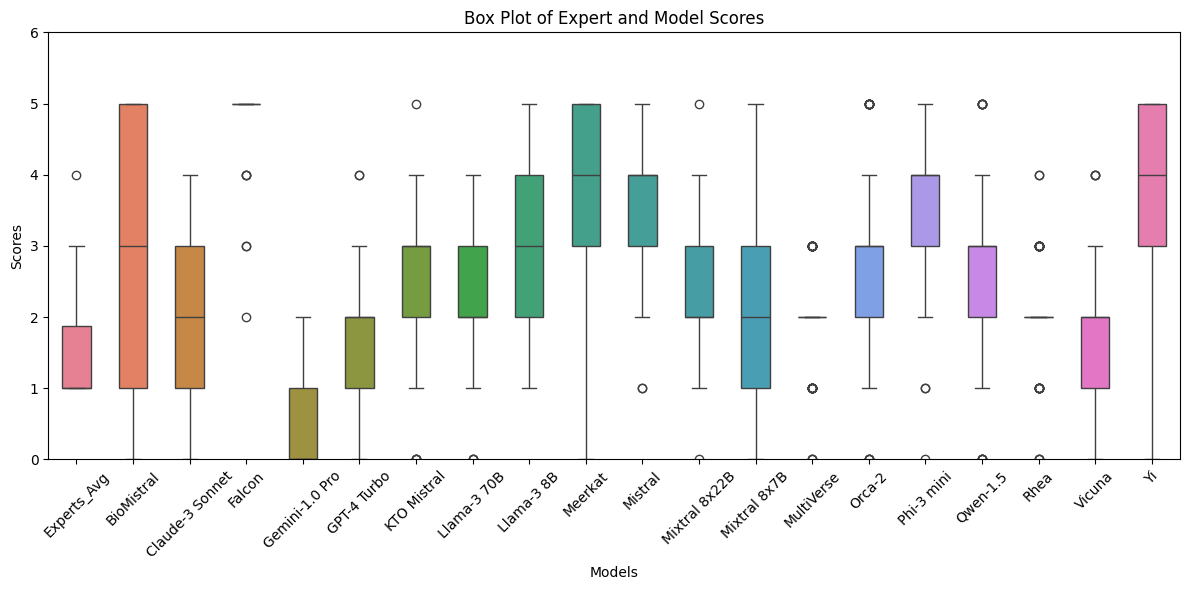

In [12]:
_ = create_plot('boxplot', data=groupA_df[['Experts_Avg'] + model_names],
            figsize=(12, 6), ylim=(0, 6),
            xlabel='Models', ylabel='Scores',
            title='Box Plot of Expert and Model Scores',
            xticks_rotation=45)

Expert-Models Inter-Rater Agreement

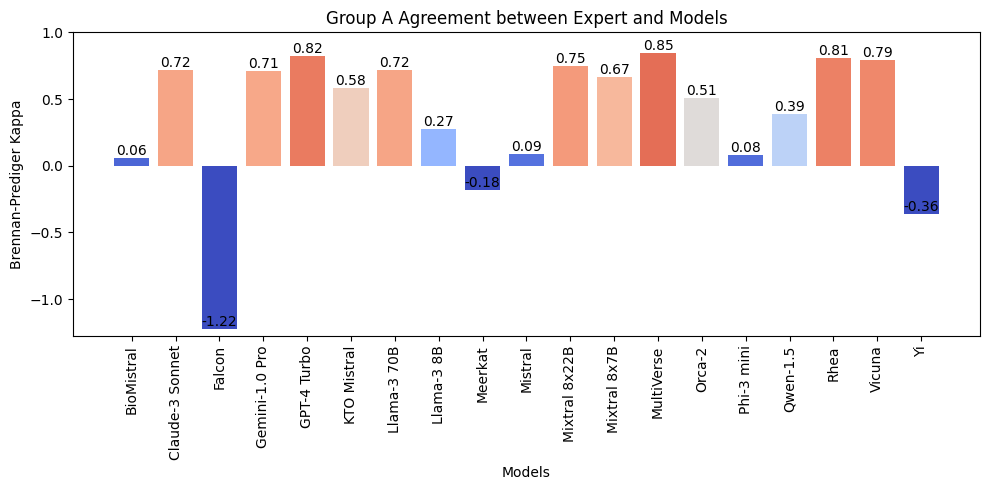

In [16]:
rater1_columns = ['Experts_Avg'] * len(model_names)

groupA_agreement = calculate_stat_df(groupA_df, rater1_columns, model_names,
                                         categories, agreement_coef, weights_type)

_ = create_plot('bar', data=groupA_agreement,
                figsize=(10,5), xlabel='Models', ylabel=agreement_coef,
                title=f'{topic_name} Agreement between Expert and Models',
                xticks_rotation=90)

# groupA_agreement = groupA_agreement.T.rename_axis('Model', axis=1)
# groupA_agreement.round(2)

Models Inter-Rater Agreement

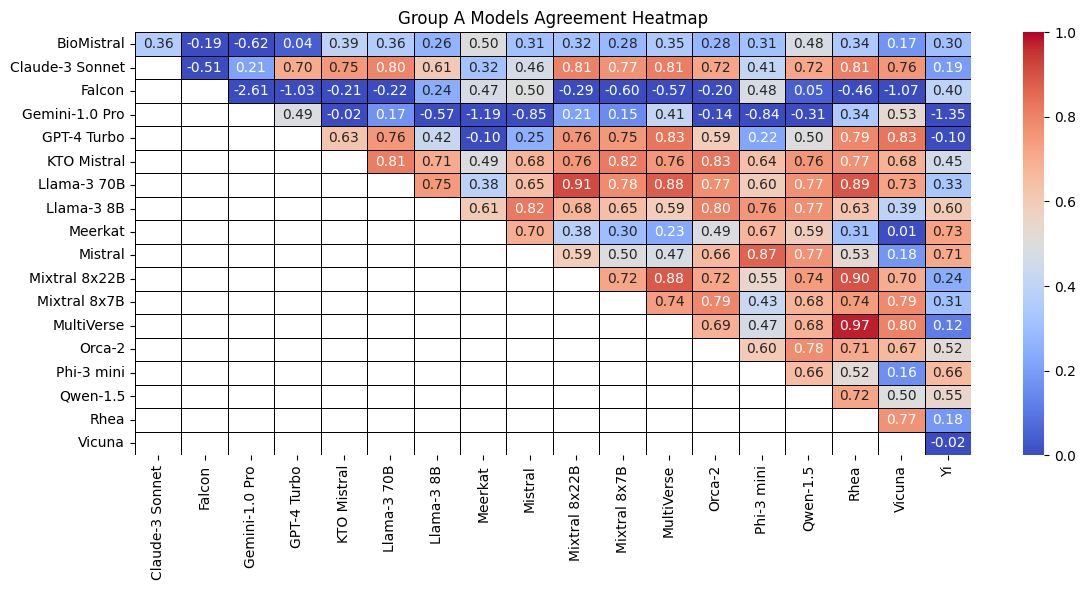

In [17]:
models_agreementA_df = calculate_models_agreement(groupA_df, model_names,
                                                  categories, agreement_coef, weights_type)

_ = create_plot('heatmap', data=models_agreementA_df,
                figsize=(12,6),
                title=f'{topic_name} Models Agreement Heatmap',
                xticks_rotation=90)

In [ ]:
model_agreements_gt_x_percent(models_agreementA_df, 0.8, topic_name, figsize=(8, 4))

### Total Score Analysis
Total scores out of 75.

In [18]:
topic_name = 'Total Score'
categories = list(range(15,76))
agreement_coef = 'Brennan-Prediger Kappa'
weights_type = 'quadratic'

Experts Agreement

In [19]:
agreement_expert1_vs_expert2 = calculate_statistics(groupB_df, 'Expert1', 'Expert2', categories, weights_type)
print(f'Agreement between Expert 1 and Expert 2:')
pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']).round(2)

Agreement between Expert 1 and Expert 2:


,Value
Weighted Kappa,0.88
Kendall's Tau,0.80
Spearman's Rho,0.93
Brennan-Prediger Kappa,0.96
Gwet's AC2,0.97


Distribution of Total Experts Scores

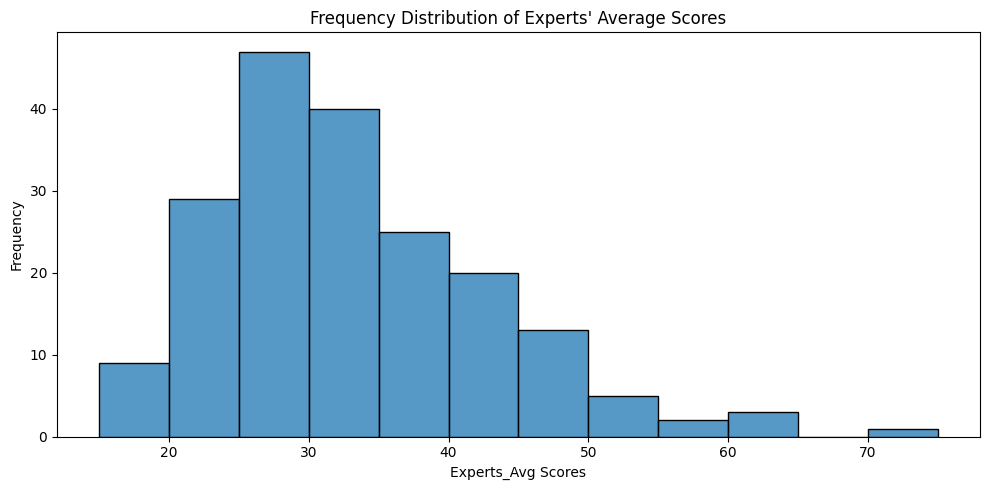

In [20]:
bins = list(range(15,80,5))
_ = create_plot('histplot', groupB_df, x='Experts_Avg', bins=bins,
                xlabel='Experts_Avg Scores', ylabel='Frequency',
                title="Frequency Distribution of Experts' Average Scores",
                figsize=(10,5))

Distribution of Scores Across Questions

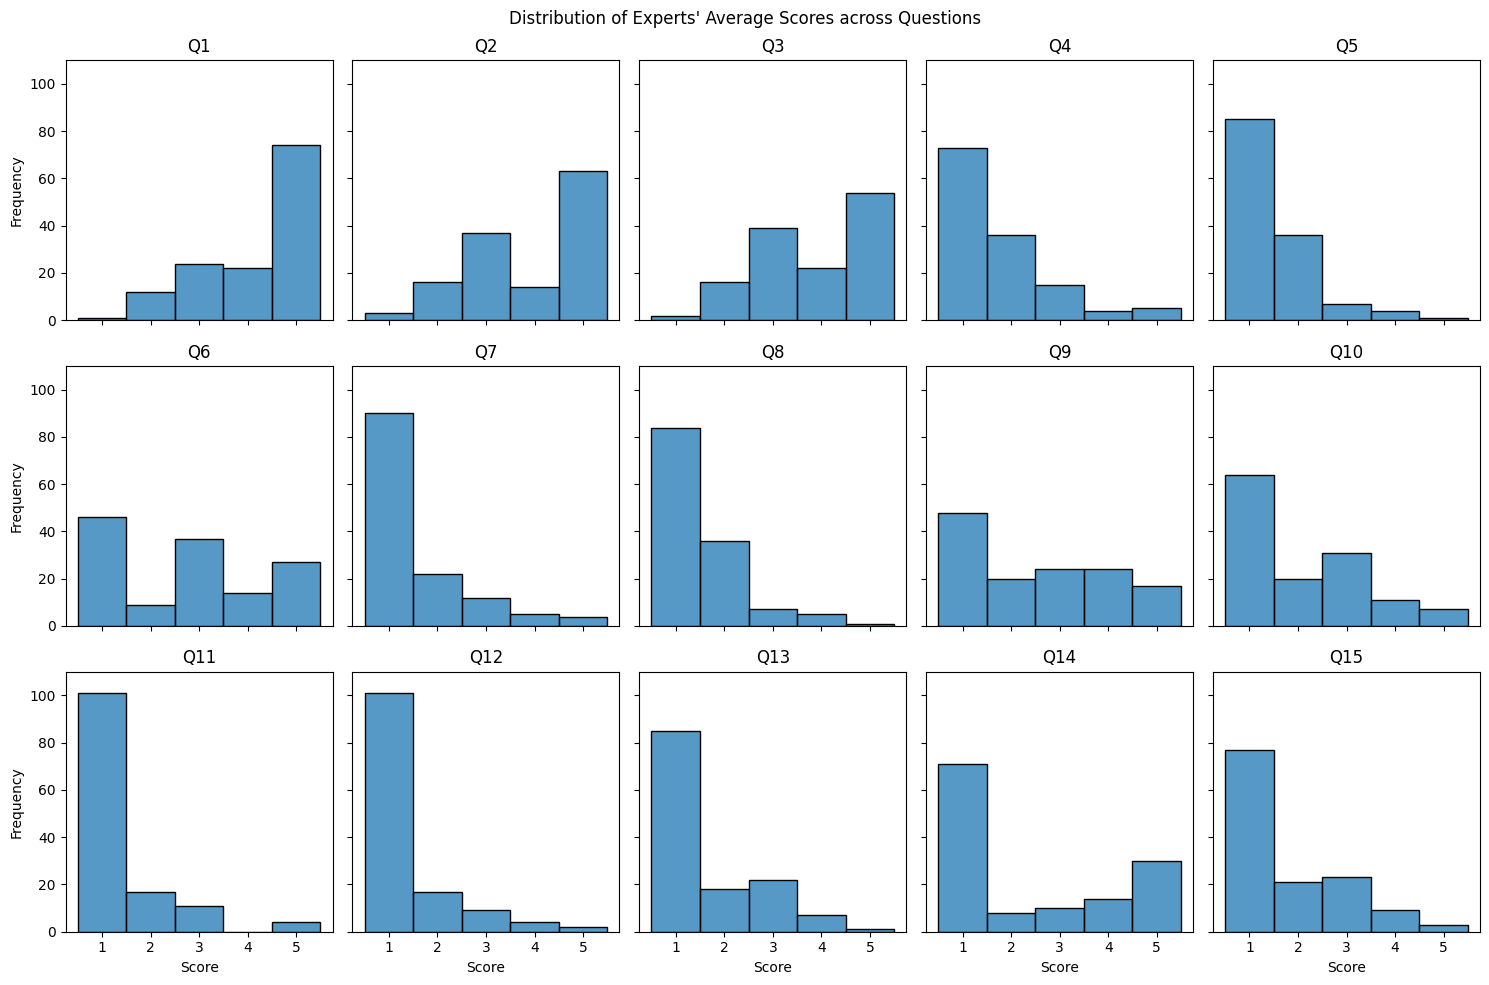

In [21]:
filtered_groupB_df = filter_df_by_topics(groupB_df, TOPICS, ['CH', 'TF', 'PN'], EXPERTS_AVG_COLUMNS)

fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Iterate over each column and create a countplot
for i, (expert_column, q_column) in enumerate(zip(EXPERTS_AVG_COLUMNS, QUESTIONS_COLUMNS)):
    create_plot('histplot', filtered_groupB_df, 
                x=expert_column, ax=axes[i],
                title=q_column, xlabel='Score', ylabel='Frequency',
                ylim=(0,110), bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

fig.suptitle("Distribution of Experts' Average Scores across Questions")

plt.tight_layout()
plt.show()

#### Descriptive Statistics

In [25]:
descriptive_statB_df = groupB_df.copy().describe().round(2).T
descriptive_statB_df.rename_axis('Model', axis=1, inplace=True)

rows_to_keep = ['Experts_Avg'] + model_names
descriptive_statB_df = descriptive_statB_df.loc[rows_to_keep, ['mean', 'std']]
descriptive_statB_df

Model,mean,std
Experts_Avg,32.80,9.82
Gemini-1.0 Pro,37.02,8.45
MultiVerse,39.82,7.99
Rhea,43.60,7.66
Mixtral 8x22B,43.54,7.71
GPT-4 Turbo,44.31,8.20
Llama-3 70B,45.98,7.66
Llama-3 8B,48.30,9.26
Mixtral 8x7B,49.03,10.08
Claude-3 Sonnet,49.13,9.73


Box Plot

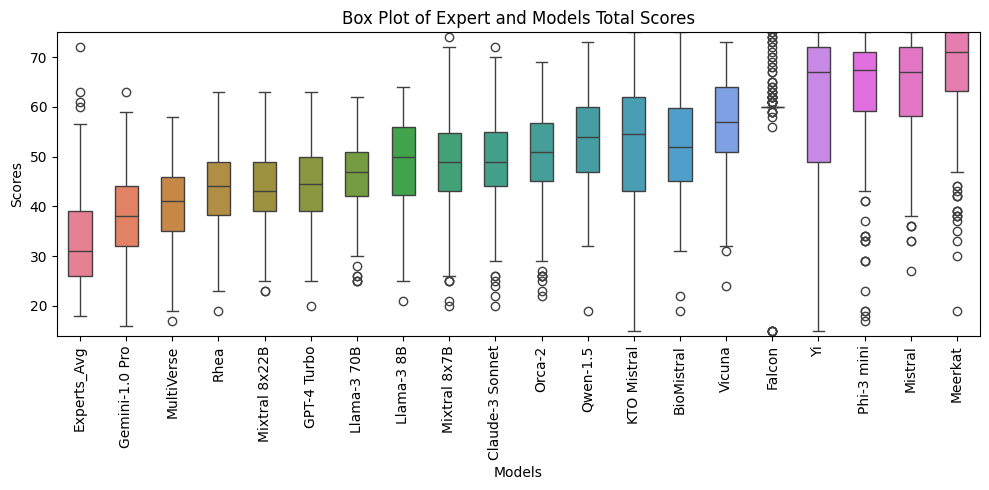

In [26]:
_ = create_plot('boxplot', data=groupB_df[['Experts_Avg'] + model_names],
                figsize=(10, 5), ylim=(14, 75),
                xlabel='Models', ylabel='Scores',
                title='Box Plot of Expert and Models Total Scores',
                xticks_rotation=90)

#### Expert-Models Inter-Rater Agreement

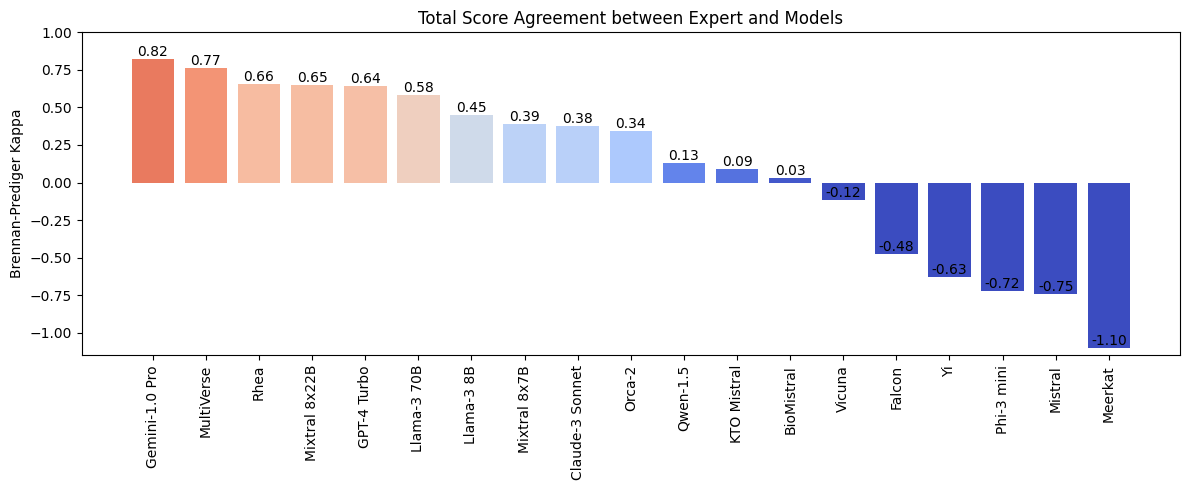

In [24]:
rater1_columns = ['Experts_Avg'] * len(model_names)

total_agreement_df = calculate_stat_df(groupB_df, rater1_columns, model_names, categories, agreement_coef, weights_type)
sorted_total_agreement_df = total_agreement_df.copy().T.sort_values(by='Brennan-Prediger Kappa', ascending=False)
model_names = sorted_total_agreement_df.index.tolist()

_ = create_plot('bar', sorted_total_agreement_df.T,
                figsize=(12, 5), ylabel=agreement_coef,
                title=f"{topic_name} Agreement between Expert and Models",
                xticks_rotation=90)

# stat_groupB_df = stat_groupB_df.T.rename_axis('Model', axis=1)
# stat_groupB_df.round(2)

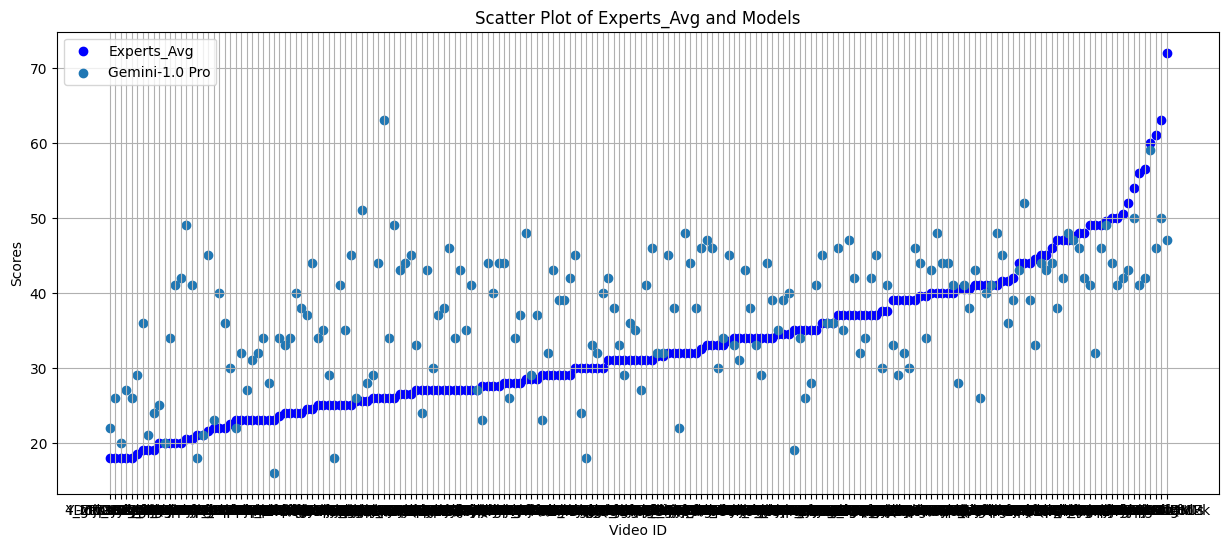

In [27]:
groupB_df_sorted = groupB_df.sort_values(by='Experts_Avg')

plt.figure(figsize=(15, 6))

# Scatter plot for Experts_Avg
plt.scatter(groupB_df_sorted['Video ID'], groupB_df_sorted['Experts_Avg'], color='blue', label='Experts_Avg')

# Scatter plot for each model
for model in ['Gemini-1.0 Pro']:#, 'MultiVerse', 'GPT-4 Turbo']:
    plt.scatter(groupB_df_sorted['Video ID'], groupB_df_sorted[model], label=model)

plt.xlabel('Video ID')
plt.ylabel('Scores')
plt.title('Scatter Plot of Experts_Avg and Models')
plt.legend()
plt.grid(True)
plt.show()

### Question-Wise Analysis
Individual 15 scores

In [28]:
topic_name = 'Question-Wise Score'
categories = list(range(1,6))

Experts Inter-Rater Agreement

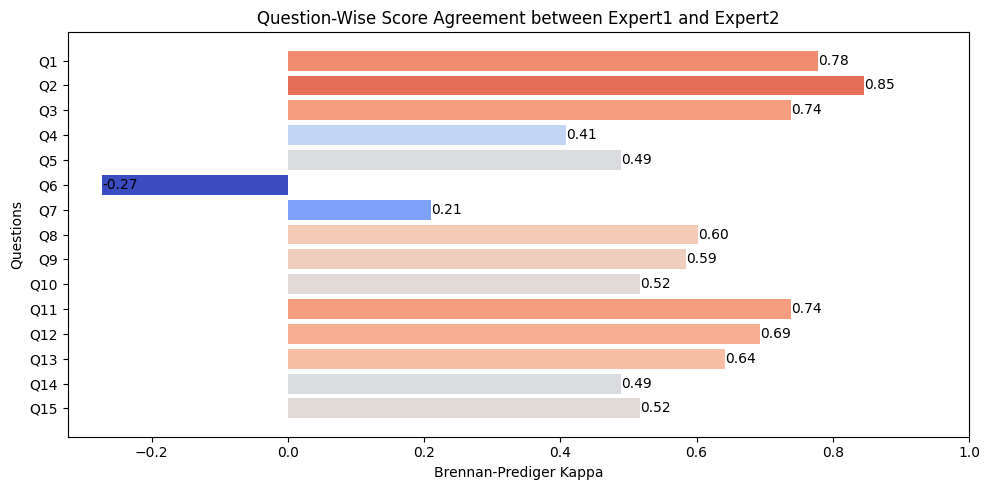

In [29]:
experts_qw_agreement = calculate_stat_df(groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                                         categories, agreement_coef, weights_type, output_df_column_names=QUESTIONS_COLUMNS)

_ = create_plot('barh', data=experts_qw_agreement,
                figsize=(10,5), xlabel=agreement_coef, ylabel='Questions',
                title=f'{topic_name} Agreement between Expert1 and Expert2',
                xticks_rotation=0)

#### Expert-Model Inter-Rater Agreement

In [30]:
qw_agreement_df = pd.DataFrame(index=QUESTIONS_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num, expert_col in enumerate(EXPERTS_AVG_COLUMNS, start=1):
        model_col = f'{model_name} Q{question_num}'
        statistics = calculate_statistics(groupB_df, expert_col, model_col, categories, weights_type)
        qw_agreement_df.at[f'Q{question_num}', model_name] = round(statistics.get(agreement_coef), 2)

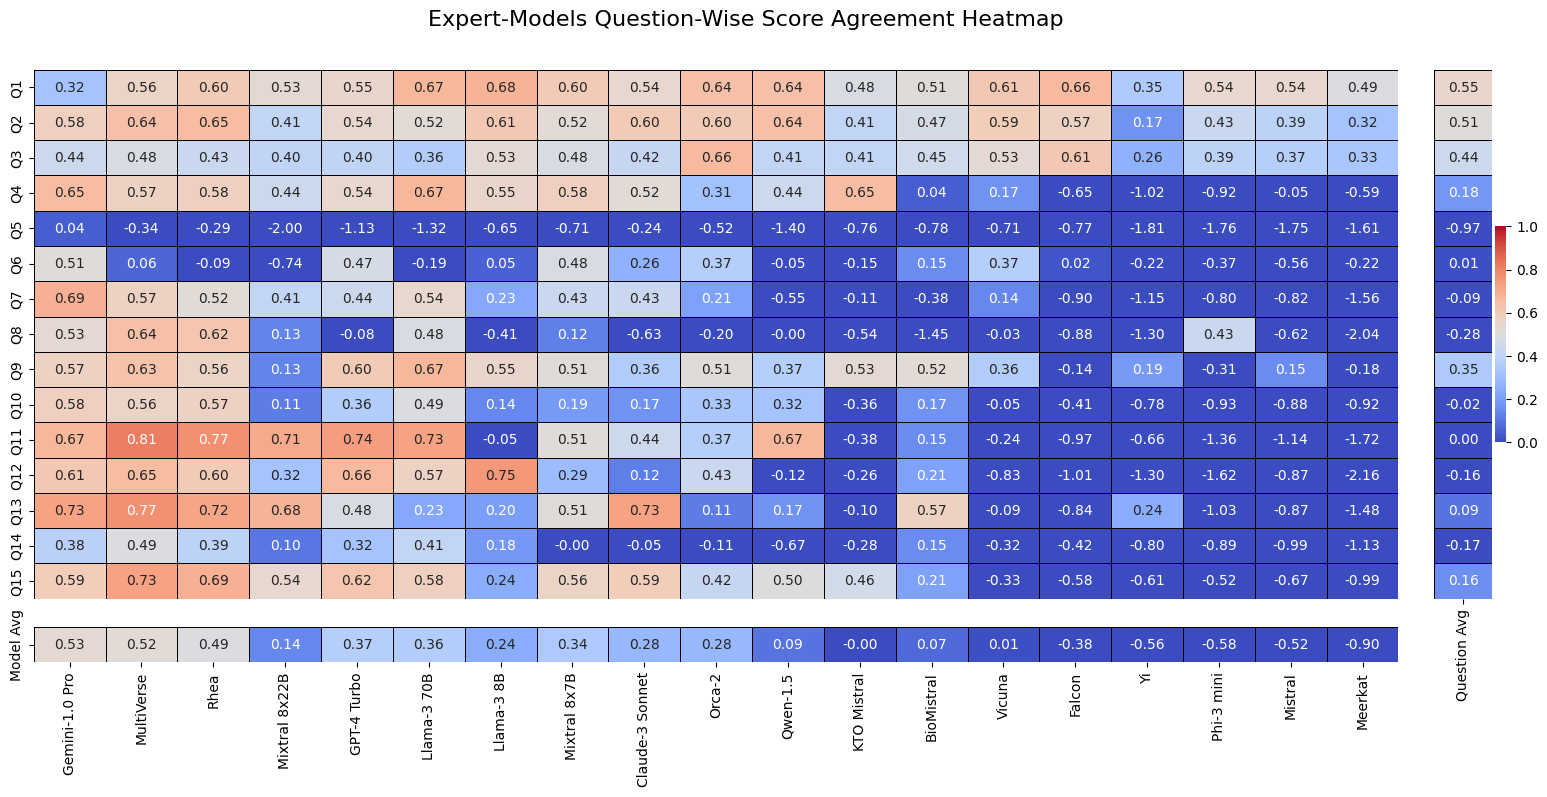

In [31]:
_ = questionwise_agreement_heatmap(qw_agreement_df, topic_name)#, figsize=(14,6))

#### Removing distant ratings between Expert 1 and Expert 2

In [32]:
cleaned_experts_groupB_df, num_of_distant_ratings_per_q = remove_distant_ratings(
    groupB_df, QUESTIONS_COLUMNS, EXPERT1_COLUMNS, EXPERT2_COLUMNS, max_diff=1
)

Q1: Length of videos with distant ratings: 6
Q2: Length of videos with distant ratings: 2
Q3: Length of videos with distant ratings: 8
Q4: Length of videos with distant ratings: 12
Q5: Length of videos with distant ratings: 8
Q6: Length of videos with distant ratings: 20
Q7: Length of videos with distant ratings: 15
Q8: Length of videos with distant ratings: 8
Q9: Length of videos with distant ratings: 14
Q10: Length of videos with distant ratings: 12
Q11: Length of videos with distant ratings: 8
Q12: Length of videos with distant ratings: 8
Q13: Length of videos with distant ratings: 10
Q14: Length of videos with distant ratings: 9
Q15: Length of videos with distant ratings: 13


In [33]:
count_notna = cleaned_experts_groupB_df[EXPERTS_AVG_COLUMNS].notna().sum()

videos_count_df = pd.DataFrame({'Count': count_notna.values}, index=QUESTIONS_COLUMNS)
videos_count_df

,Count
Q1,127
Q2,131
Q3,125
Q4,121
Q5,125
Q6,113
Q7,118
Q8,125
Q9,119
Q10,121


Experts Inter-Rater Agreement

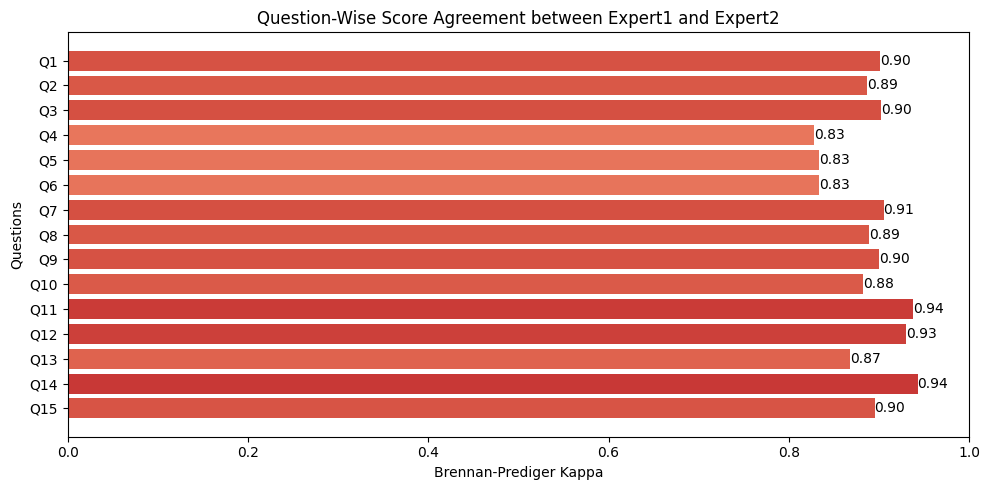

In [34]:
experts_qw_agreement = calculate_stat_df(cleaned_experts_groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                                         categories, agreement_coef, weights_type, output_df_column_names=QUESTIONS_COLUMNS)

_ = create_plot('barh', data=experts_qw_agreement,
                figsize=(10,5), xlabel=agreement_coef, ylabel='Questions',
                title=f'{topic_name} Agreement between Expert1 and Expert2',
                xticks_rotation=0)

Expert-Model Inter-Rater Agreement

In [38]:
cleaned_qw_agreement_df = pd.DataFrame(index=QUESTIONS_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num, expert_col in enumerate(EXPERTS_AVG_COLUMNS, start=1):
        model_col = f'{model_name} Q{question_num}'
        statistics = calculate_statistics(cleaned_experts_groupB_df, expert_col, model_col, categories, weights_type)
        cleaned_qw_agreement_df.at[f'Q{question_num}', model_name] = round(statistics.get(agreement_coef), 2)

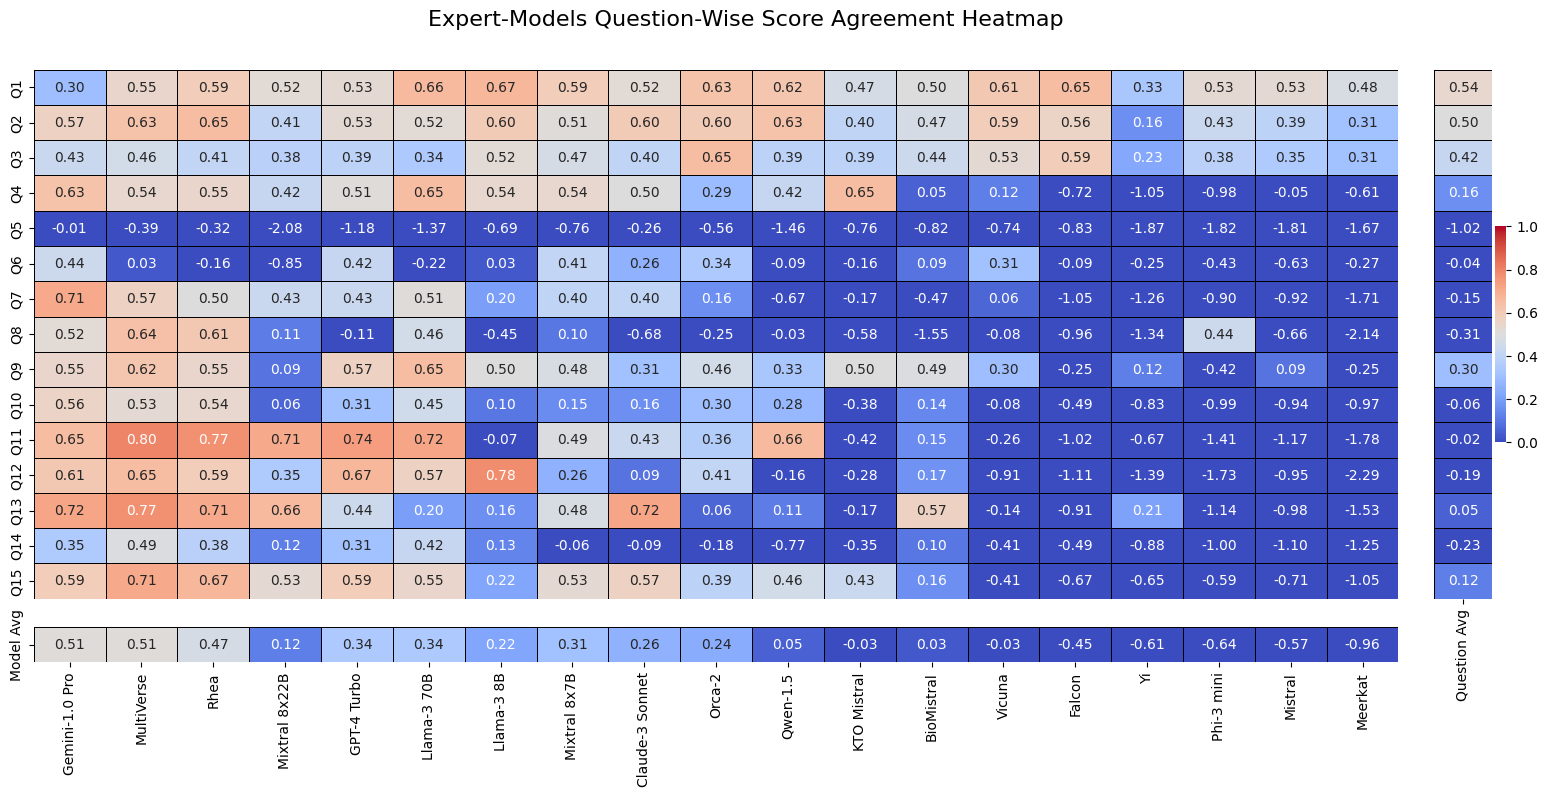

In [39]:
_ = questionwise_agreement_heatmap(cleaned_qw_agreement_df, topic_name)#, figsize=(14,6))

['Gemini-1.0 Pro', 'MultiVerse', 'Rhea', 'GPT-4 Turbo', 'Llama-3 70B', 'Mixtral 8x7B', 'Claude-3 Sonnet']


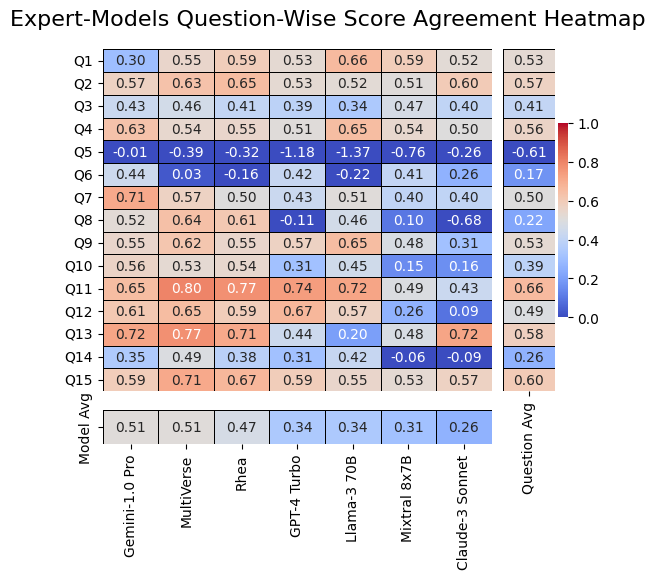

In [44]:
# Displaying models with average agreement above `avg_threshold`
def filtering_qw_agreement(qw_agreement_df, avg_threshold=0.25):
    model_avg = qw_agreement_df.mean(axis=0).round(2)
    model_names_above_threshold = model_avg[model_avg > avg_threshold].index.tolist()
    return qw_agreement_df[model_names_above_threshold]

cleaned_qw_agreement_filtered = filtering_qw_agreement(cleaned_qw_agreement_df)

_ = questionwise_agreement_heatmap(cleaned_qw_agreement_filtered, topic_name, figsize=(10,6))

## Models Inter-Rater Agreement

In [45]:
topic_name = 'Total Score'
categories = list(range(15,76))

In [46]:
good_threshold = 0.6
bad_threshold = 0.2

good_models = sorted_total_agreement_df[sorted_total_agreement_df['Brennan-Prediger Kappa'] > good_threshold].index.tolist()
moderate_models = sorted_total_agreement_df[(sorted_total_agreement_df['Brennan-Prediger Kappa'] <= good_threshold) 
                                        & (sorted_total_agreement_df['Brennan-Prediger Kappa'] > bad_threshold)].index.tolist()
bad_models = sorted_total_agreement_df[sorted_total_agreement_df['Brennan-Prediger Kappa'] <= bad_threshold].index.tolist()

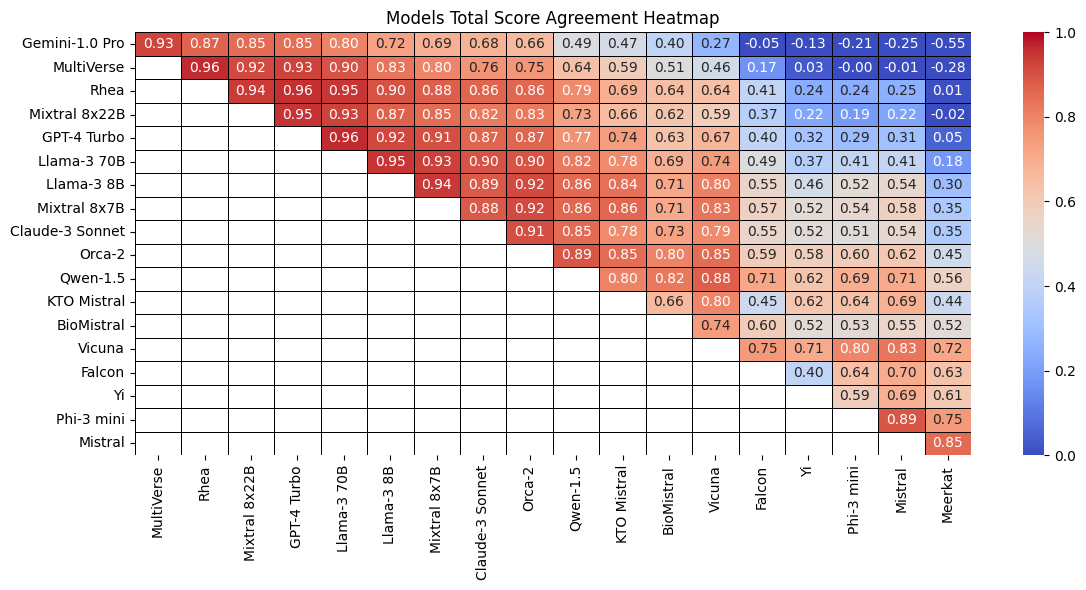

In [47]:
models = good_models + moderate_models + bad_models
models_agreementB_df = calculate_models_agreement(groupB_df[['Video ID'] + models], models, 
                                                     categories, agreement_coef, weights_type)

_ = create_plot('heatmap', data=models_agreementB_df,
                figsize=(12,6),
                title=f'Models {topic_name} Agreement Heatmap',
                xticks_rotation=90)

## Displaying samples of responses by LLMs

In [ ]:
model_file = '../../../Results/LLMs_Responses/gemini-1.0-pro-latest-response.csv'
model_responses_df = pd.read_csv(model_file, encoding='utf-8')

model_responses_df = merge_dataframes(model_responses_df, cleaned_experts_groupB_df, ['Video ID'] + EXPERTS_AVG_COLUMNS)

model_responses_df.head(2)

In [ ]:
diff = 4    # 0 for high agreement, 2 for medium, and 4 for low
q_num = 5

# Filter rows where the difference between Q6 and Experts_Avg Q6 is 'diff'
filtered_df = model_responses_df[model_responses_df[f'Q{q_num}'] - model_responses_df[f'Experts_Avg Q{q_num}'] == diff]

# Display one example of Response_6 where the difference is diff
if not filtered_df.empty:
    example_row = filtered_df.iloc[1]
    response = example_row[f'Response_{q_num}']
    q_score = example_row[f'Q{q_num}']
    avg_score = example_row[f'Experts_Avg Q{q_num}']
    print(example_row['Video ID'])
    print(f'Example Response_{q_num} where Q{q_num}={q_score} and Experts_Avg Q{q_num}={avg_score} have a difference of {diff}:\n{response}')
else:
    print(f'No examples found where Q{q_num} and Experts_Avg Q{q_num} have a difference of {diff}.')